In [44]:
import os
import numpy as np
import cv2
import json 

# ------------------------------
# ENTER YOUR REQUIREMENTS HERE:
# ...
PATH_TO_YOUR_IMAGES = 'testdata/extrinsic_calib_set_1/'
MARKER_LENGTH = 0.25
# ------------------------------

json_file_path = './calibration.json'

with open(json_file_path, 'r') as file: # Read the JSON file
    json_data = json.load(file)

mtx = np.array(json_data['mtx'])
dst = np.array(json_data['dist'])

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_36h11) # TODO: difference between 36h11 and 36H11
params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(dictionary, params)

In [45]:
image_paths = [os.path.join(PATH_TO_YOUR_IMAGES, f) for f in os.listdir(PATH_TO_YOUR_IMAGES) if f.endswith(".JPG")]

img_path = image_paths[5] # select image
image_color = cv2.imread(img_path)
image = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

h,  w = image.shape[:2]
#newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dst, (w,h), 1, (w,h))
#image = cv2.undistort(image, mtx, dst, None, newcameramtx)


marker_corners, marker_ids, rejectedCandidates = detector.detectMarkers(image)
marker_corners

rvecs, tvecs, objpts = cv2.aruco.estimatePoseSingleMarkers(marker_corners, markerLength=MARKER_LENGTH, cameraMatrix=mtx, distCoeffs=dst)
marker_ids = [v.item() for v in marker_ids]
# objpts consistent across markers

In [46]:
rvecs, tvecs, marker_ids

(array([[[ 1.89914224, -1.7293225 ,  0.32871431]],
 
        [[ 0.4586851 ,  2.80251794, -0.52765062]],
 
        [[ 0.22926396,  3.20810836,  0.09182678]]]),
 array([[[-0.9081883 , -0.26148593,  1.38576549]],
 
        [[ 1.47876824,  0.15076661,  1.78698031]],
 
        [[ 0.50006231,  0.9771672 ,  2.2708553 ]]]),
 [15, 12, 14])

In [47]:
rvecs[0,0,:]

array([ 1.89914224, -1.7293225 ,  0.32871431])

In [48]:
objpts.reshape((-1,3))

array([[-0.125,  0.125,  0.   ],
       [ 0.125,  0.125,  0.   ],
       [ 0.125, -0.125,  0.   ],
       [-0.125, -0.125,  0.   ]], dtype=float32)

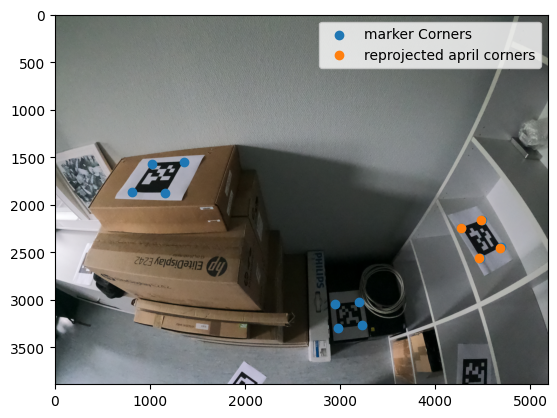

In [49]:
REPR_MARKER=1
rvec = rvecs[REPR_MARKER,0,:]
tvec = tvecs[REPR_MARKER,0,:]
rotation_matrix, _ = cv2.Rodrigues(rvec)

# Camera pose: the inverse of the extrinsic matrix (rotation + translation)
camera_extrinsics = np.eye(4)
camera_extrinsics[:3, :3] = rotation_matrix
tvec = tvec.flatten()
#tvec = - rotation_matrix.T @ (tvec)
camera_extrinsics[:3, 3] = tvec
camera_mat = np.eye(4)
camera_mat[:3,:3] = mtx
P = camera_mat @ camera_extrinsics
P = P[:3,:] # we only had 4 rows for multiplication before
world_corners = objpts.reshape((-1,3))
image_pts = P @ np.hstack((world_corners,np.ones((world_corners.shape[0],1)))).T
# recover homogeneous coordinates
image_pts = image_pts / image_pts[-1,:]
image_pts = image_pts[:2,:]
image_pts.T
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.scatter(np.hstack(marker_corners)[0,:,0],np.hstack(marker_corners)[0,:,1],label="marker Corners")
plt.scatter(image_pts[0,:],image_pts[1,:], label="reprojected april corners")
plt.legend()

move points to coordinate system with camera in center

In [50]:
REPR_MARKER=1
rvec = rvecs[REPR_MARKER,0,:].flatten()
tvec = tvecs[REPR_MARKER,0,:]
rotation_matrix, _ = cv2.Rodrigues(rvec)

# rvec and tvec describe the transform from marker coordinates to camera coordinates with the inverse rigid transformation being the camera pose
# thus rvec and tvec already are the pose of the marker and the inverse (=camera pose)describes the transformation from camera to marker coords


# Camera pose: the inverse of the extrinsic matrix (rotation + translation)
rigid_motion = np.eye(4)
rigid_motion[:3, :3] = rotation_matrix
rigid_motion[:3,3] = tvec
marker_world_corners = objpts.reshape((-1,3))
marker_world_corners_cam = rigid_motion @ np.hstack((marker_world_corners,np.ones((marker_world_corners.shape[0],1)))).T
marker_world_corners_cam = marker_world_corners_cam[:3,:].T
marker_world_corners_cam



array([[1.63720495, 0.22916661, 1.78586378],
       [1.40758294, 0.29353881, 1.71083077],
       [1.32033152, 0.07236661, 1.78809684],
       [1.54995353, 0.0079944 , 1.86312985]])

In [51]:
def convert_to_cam_system(rvec, tvec, marker_world_corners):
    rvec = rvec.flatten()
    rotation_matrix, _ = cv2.Rodrigues(rvec)
    rigid_motion = np.eye(4)
    rigid_motion[:3, :3] = rotation_matrix
    rigid_motion[:3,3] = tvec
    marker_world_corners_cam = rigid_motion @ np.hstack((marker_world_corners,np.ones((marker_world_corners.shape[0],1)))).T
    marker_world_corners_cam = marker_world_corners_cam[:3,:].T
    return marker_world_corners_cam, rigid_motion
    

In [52]:
from collections import defaultdict

img_markers = dict()
for rvec, tvec, mid in zip(rvecs, tvecs, marker_ids):
    wpts, trans = convert_to_cam_system(rvec, tvec, marker_world_corners=objpts.reshape((-1,3)))
    # note that these trans tranforms are pose matrices
    img_markers[mid] = (wpts, trans)

In [53]:
def estimate_april_pose(img_path):
    image_color = cv2.imread(img_path)
    image = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    h,  w = image.shape[:2]
    #newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dst, (w,h), 1, (w,h))
    #image = cv2.undistort(image, mtx, dst, None, newcameramtx)


    marker_corners, marker_ids, rejectedCandidates = detector.detectMarkers(image)
    marker_corners

    rvecs, tvecs, objpts = cv2.aruco.estimatePoseSingleMarkers(marker_corners, markerLength=MARKER_LENGTH, cameraMatrix=mtx, distCoeffs=dst)
    marker_ids = [v.item() for v in marker_ids]
    return rvecs, tvecs, marker_ids, objpts

In [54]:
import plotly.graph_objects as go
from stl import mesh
def plot_3d_points_and_camera_centers(points, extrinsic_matrices):
    """
    Plots a 3D scatter plot of the given points and camera representations from extrinsic matrices.

    Parameters:
    - points: A 3xN NumPy array, where each column represents a point (x, y, z).
    - extrinsic_matrices: A list of 4x4 NumPy arrays representing the extrinsic matrices for each camera.
    """
    # Ensure points is a NumPy array
    points = np.asarray(points)

    # Check if the input is a 3xN array
    if points.shape[0] != 3:
        raise ValueError("Input points must be a 3xN NumPy array.")

    # Extract x, y, z coordinates
    x = points[0, :]
    y = points[1, :]
    z = points[2, :]

    # Create a 3D scatter plot for the points
    fig = go.Figure(data=[go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=5,
            color='blue',  # Marker color for points
            opacity=0.8
        ),
        name='3D Points'
    )])

    def create_camera_cone(extrinsic, name, color=None):
        # Transform the cone points using the extrinsic matrix
        rotation_matrix = extrinsic[:3, :3].T
        camera_center = -rotation_matrix @ extrinsic[:3, 3]

        # def rotate_and_translate(vertices, rotation_matrix, translation_vector):
        #     # Apply rotation
        #     rotated_vertices = vertices @ rotation_matrix.T  # Ensure correct shape
        #     # Apply translation
        #     translated_vertices = rotated_vertices + translation_vector
        #     return translated_vertices

        # # Load the STL file
        # your_mesh = mesh.Mesh.from_file('pyramid.stl')

        # # Extract vertices
        # vertices = your_mesh.vectors.reshape(-1, 3)

        # # Rotate and translate the frustum
        # transformed_vertices = rotate_and_translate(vertices, rotation_matrix, camera_center)

        # # Compute forward vector 
        # frustum = go.Mesh3d(
        #     x=transformed_vertices[:, 0],
        #     y=transformed_vertices[:, 1],
        #     z=transformed_vertices[:, 2],
        #     opacity=0.75,
        #     color='blue'
        # )

        # Create axes representing the camera's orientation
        axes_length = 0.25
        x_axis = go.Scatter3d(
            x=[camera_center[0], camera_center[0] + axes_length * rotation_matrix[0, 0]],
            y=[camera_center[1], camera_center[1] + axes_length * rotation_matrix[1, 0]],
            z=[camera_center[2], camera_center[2] + axes_length * rotation_matrix[2, 0]],
            mode='lines',
            line=dict(color='red', width=5),
            name=name
        )

        y_axis = go.Scatter3d(
            x=[camera_center[0], camera_center[0] + axes_length * rotation_matrix[0, 1]],
            y=[camera_center[1], camera_center[1] + axes_length * rotation_matrix[1, 1]],
            z=[camera_center[2], camera_center[2] + axes_length * rotation_matrix[2, 1]],
            mode='lines',
            line=dict(color='green', width=5),
            name=name
        )

        z_axis = go.Scatter3d(
            x=[camera_center[0], camera_center[0] + axes_length * rotation_matrix[0, 2]],
            y=[camera_center[1], camera_center[1] + axes_length * rotation_matrix[1, 2]],
            z=[camera_center[2], camera_center[2] + axes_length * rotation_matrix[2, 2]],
            mode='lines',
            line=dict(color='blue', width=5),
            name=name
        )

        dot = None
        if color is not None:
            dot = go.Scatter3d(
                x=[camera_center[0]],
                y=[camera_center[1]],
                z=[camera_center[2]],
                mode='markers',
                marker=dict(
                    size=5,
                    color=color,  # Marker color for points
                    opacity=1.0
                ),
                name=name
            )

        res = [x_axis, y_axis, z_axis]
        if dot is not None:
            res.append(dot)
        return res

    # Plot camera representations from extrinsic matrices
    for idx, tp in enumerate(extrinsic_matrices):
        if isinstance(tp, tuple):
            if len(tp) == 2:
                name= tp[0]
                color=None
                extrinsic = tp[1]
            elif len(tp) == 3:
                name=tp[0]
                color=tp[1]
                extrinsic=tp[2]
        else:
            extrinsic = tp
            color=None
            name = f"cam_{idx}"
        # Create the camera cone
        cone_point_objects = create_camera_cone(extrinsic, name,color=color)

        # Add the cone to the plot
        [fig.add_trace(cone_points) for cone_points in cone_point_objects]

    # Set the layout
    fig.update_layout(
        title='3D Scatter Plot of Points and Camera Representations',
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis'
        )
    )

    # Show the figure in the Jupyter Notebook
    fig.show()

origin_cam_ext = np.eye(4)

# Define a list of extrinsic matrices (4x4)
extrinsic_matrices = [
    origin_cam_ext
]
for (m, trans) in img_markers.values():
    wpts = np.vstack((wpts, m))
    _r = trans[:3,:3]
    _r = _r.T
    _t =  (-_r)@trans[:3,3]
    _E = np.eye(4)
    _E[:3,:3] = _r
    _E[:3,3] = _t
    extrinsic_matrices.append(_E)

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

In [55]:
rvecs, tvecs, marker_ids, objpts = estimate_april_pose(image_paths[6])
img_markers_2 = dict()
for rvec, tvec, mid in zip(rvecs, tvecs, marker_ids):
    wpts, trans = convert_to_cam_system(rvec, tvec, marker_world_corners=objpts.reshape((-1,3)))
    # note that these trans tranforms are pose matrices
    img_markers_2[mid] = (wpts, trans)

In [56]:
img_markers.keys(), img_markers_2.keys()

(dict_keys([15, 12, 14]), dict_keys([15, 10, 11]))

convert img_markers_2 to img_markers frame of reference

In [57]:
# goal is pose of marker 11
img_markers[15][1]

array([[ 0.14444374, -0.97338876, -0.17790538, -0.9081883 ],
       [-0.84022675, -0.02569094, -0.54162623, -0.26148593],
       [ 0.52264233,  0.22771537, -0.82157818,  1.38576549],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [58]:
# move cam 2 to img_marker (out edge, trans is pose)
trans = img_markers_2[15][1]
_r = trans[:3,:3]
_r = _r.T
_t =  -_r@trans[:3,3]
_E = np.eye(4)
_E[:3,:3] = _r
_E[:3,3] = _t
new_cam_pos = img_markers[15][1] @ _E  # second factor here is the pose of connecting marker 11 as seen from frame of reference 2
new_cam_pos = new_cam_pos[:3, :]

# this was calculated as (cam_1)-[pose]->(15)<-[trans]-(cam_2)


In [59]:
new_cam_pos

array([[ 0.16097715,  0.98511074, -0.06035889, -0.73953705],
       [-0.96872423,  0.16940863,  0.18131213,  0.28464947],
       [ 0.18883784,  0.02928401,  0.98157155, -0.02683687]])

now try the rebind neighbors with a third frame of reference

In [60]:
# rvecs, tvecs, marker_ids, objpts = estimate_april_pose(image_paths[1])
# img_markers_3 = dict()
# for rvec, tvec, mid in zip(rvecs, tvecs, marker_ids):
#     wpts, trans = convert_to_cam_system(rvec, tvec, marker_world_corners=objpts.reshape((-1,3)))
#     # note that these trans tranforms are pose matrices
#     img_markers_3[mid] = (wpts, trans)

# img_markers_3.keys()

In [61]:
# actually stored is always pose, label is according to aggregation direction
# (cam1)-pose->(m15)<-trans-(cam2)-pose->(m11)
# => (cam1)-pose->(m15)<-trans-(cam2)<-trans-(m11)
# => (cam1)-pose->(m15)<-trans15-2 @ trans2_11-(m11)

pose = img_markers[15][1]

trans152 = img_markers_2[15][1]
_r = trans152[:3,:3]
_r = _r.T
_t =  -_r@trans152[:3,3]
_E152 = np.eye(4)
_E152[:3,:3] = _r
_E152[:3,3] = _t

trans211 = img_markers_2[11][1]
_r = trans211[:3,:3]
_r = _r.T
_t =  -_r@trans211[:3,3]
_E211 = np.eye(4)
_E211[:3,:3] = _r
_E211[:3,3] = _t
new_m11_pos = pose @ _E152 @ _E211
new_m11_pos = new_m11_pos[:3, :]

def invv(trans):
    _r = trans[:3,:3]
    _r = _r.T
    _t =  -_r@trans[:3,3]
    _E211 = np.eye(4)
    _E211[:3,:3] = _r
    _E211[:3,3] = _t
    return _E211
#new_m11_pos = invv(new_m11_pos)

In [62]:
np.hstack((img_markers_2[11][0],np.ones((4,1))))

array([[-1.03379336,  0.58092152,  3.19178048,  1.        ],
       [-0.90625102,  0.36598395,  3.18588215,  1.        ],
       [-0.69186953,  0.4925731 ,  3.20859258,  1.        ],
       [-0.81941187,  0.70751067,  3.21449091,  1.        ]])

In [63]:
m11_pts = new_cam_pos @ np.hstack((img_markers_2[11][0],np.ones((img_markers_2[11][0].shape[0],1)))).T
# recover homogeneous coordinates
m11_pts = m11_pts[:3,:]
m11_pts.T

array([[-0.52633446,  1.96323177,  2.92791646],
       [-0.71718435,  1.8021967 ,  2.93991742],
       [-0.55934028,  1.62008312,  3.0063997 ],
       [-0.36849038,  1.7811182 ,  2.99439875]])

In [64]:
new_cam_pos

array([[ 0.16097715,  0.98511074, -0.06035889, -0.73953705],
       [-0.96872423,  0.16940863,  0.18131213,  0.28464947],
       [ 0.18883784,  0.02928401,  0.98157155, -0.02683687]])

In [65]:
img_markers_2[11][0]

array([[-1.03379336,  0.58092152,  3.19178048],
       [-0.90625102,  0.36598395,  3.18588215],
       [-0.69186953,  0.4925731 ,  3.20859258],
       [-0.81941187,  0.70751067,  3.21449091]])

In [66]:
p = img_markers_2[11][0][0,:]
extrinsic = invv(new_cam_pos)
rotation_matrix = extrinsic[:3, :3]
camera_center = -rotation_matrix @ extrinsic[:3, 3]
pc =  ((-rotation_matrix).T @ extrinsic[:3, 3]) # this actually is the camera center

#p =  ((-rotation_matrix).T @ (p-camera_center)) # this actually is the camera center

_p = np.eye(4)
_p[:3,3] = p
_C = np.eye(4)
_C[:3,:4] = new_cam_pos
p = _C @ _p
p = p[:3,3]
p

array([-0.52633446,  1.96323177,  2.92791646])

for reference, manually compute pose of marker using estimated pose matrix

In [67]:
E = new_m11_pos
p2 = -E[:3,:3].T @ E[:3,3]
p2

array([-1.24751017, -0.15656355,  3.19847822])

In [68]:

origin_cam_ext = np.eye(4)

# Define a list of extrinsic matrices (4x4)
extrinsic_matrices = [
    origin_cam_ext,
    invv(new_cam_pos),
    new_m11_pos
]
wpts = np.zeros((0,3))
for (m, trans) in img_markers.values():
    wpts = np.vstack((wpts, m))
    _r = trans[:3,:3]
    _r = _r.T
    _t =  -_r@trans[:3,3]
    _E = np.eye(4)
    _E[:3,:3] = _r
    _E[:3,3] = _t
    extrinsic_matrices.append(_E)

wpts = np.vstack((wpts, pc))
wpts = np.vstack((wpts, p))

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

this is actually correct

In [69]:
import networkx as nx
import random
import numpy as np
import pathlib
seed = 42
random.seed(seed)
np.random.seed(seed)

pose_graph = nx.DiGraph()

for img_path in image_paths:
    rvecs, tvecs, marker_ids, objpts = estimate_april_pose(img_path)
    img_markers = dict()
    node_name = pathlib.Path(img_path).name
    pose_graph.add_node(node_name)
    for rvec, tvec, mid in zip(rvecs, tvecs, marker_ids):
        wpts, trans = convert_to_cam_system(rvec, tvec, marker_world_corners=objpts.reshape((-1,3)))
        # note that these trans tranforms are pose matrices
        img_markers[mid] = (wpts, trans)
        if not pose_graph.has_node(mid):
            pose_graph.add_node(mid)
        
        # _r = trans[:3,:3]
        # _r = _r.T
        # _t =  -_r@trans[:3,3]
        # _E = np.eye(4)
        # _E[:3,:3] = _r
        # _E[:3,3] = _t
        pose_graph.add_edge(node_name, mid, trans=trans, points3d=wpts.T)
    #inliers = correspondences[:, mask.astype(bool)[:,0]]
        
    
    #inliers = correspondences[:, np.where(mask)]
    #triangulatedPoints = triangulatedPoints.T
    #print(correspondences,np.where(mask), mask, triangulatedPoints.shape)

In [70]:
components = sorted(nx.connected_components(nx.Graph(pose_graph)), key=len, reverse=True)
pose_graph = pose_graph.subgraph(components[0])
print(f"graph consists of {len(components)} connected component(s), choosing largest")

graph consists of 1 connected component(s), choosing largest


In [71]:
# choosing specific subgraph for now
subgraph_nodes = ["GOPR0012.JPG","GOPR0013.JPG","GOPR0008.JPG",11,15]
pose_graph = pose_graph.subgraph(subgraph_nodes).copy()

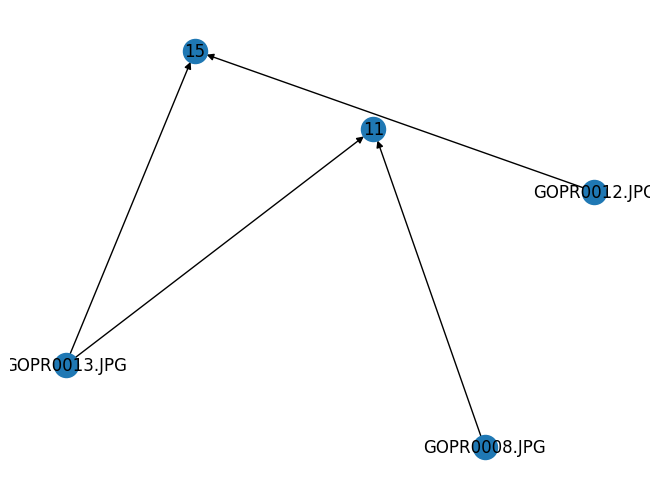

In [72]:
import matplotlib.pyplot as plt
graph_poses = nx.kamada_kawai_layout(pose_graph)

plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses)
plt.show(
)

In [73]:
seed = 42
random.seed(seed)
np.random.seed(seed)
trans_key="trans"
model_key = "model"
def inverse_transformation(T):
    return np.linalg.inv(T)

def update_data(pose_graph, pivot_node, neighbor, new_trans):
    node_data = pose_graph.nodes[pivot_node]
    new_data = {pivot_node: {**node_data}}
    new_data[pivot_node][model_key][neighbor] = new_trans
    nx.set_node_attributes(pose_graph, new_data)

In [74]:
nodes = list(pose_graph.nodes)
for n in nodes:
    n_data = pose_graph[n]
    nx.set_node_attributes(pose_graph, {n:{model_key: {n: np.eye(4)},**n_data}})

In [75]:
pivot_node = "GOPR0012.JPG"
out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key]) for n in pose_graph.out_edges(pivot_node)] 
in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key]) for n in pose_graph.in_edges(pivot_node)] 
in_neighbors = [(n, inverse_transformation(t)) for (n,t) in in_neighbors] # this lets us handle every edge if it was outgoing
neighbors = out_neighbors + in_neighbors # every transformation now is a pose matrix (as opposed to extrinsic)
for neighbor, pose in neighbors:
    print(pose_graph.nodes[pivot_node][model_key])
    print(f"pose {pose}")
    print(pose_graph.nodes[neighbor][model_key])

    # add to pivot model applying pose
    new_pose = pose @ pose_graph.nodes[neighbor][model_key][neighbor]
    update_data(pose_graph, pivot_node, neighbor, new_pose)

    # get neighbors neighbors
    out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key],n) for n in pose_graph.out_edges(neighbor)] 
    in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key],n) for n in pose_graph.in_edges(neighbor)]
    in_neighbors = [(n, inverse_transformation(t),e) for (n,t,e) in in_neighbors]
    neighbors_neighbors = out_neighbors + in_neighbors
    # reconnect to pivot node applying pose to edge
    for nn, npose, edge in neighbors_neighbors:
        if nn == pivot_node:
            continue
        pose_graph.remove_edge(*edge)
        new_pose = pose @ npose
        pose_graph.add_edge(pivot_node, nn, **{trans_key: new_pose})
    pose_graph.remove_node(neighbor)

        
    

{'GOPR0012.JPG': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}
pose [[ 0.14444374 -0.97338876 -0.17790538 -0.9081883 ]
 [-0.84022675 -0.02569094 -0.54162623 -0.26148593]
 [ 0.52264233  0.22771537 -0.82157818  1.38576549]
 [ 0.          0.          0.          1.        ]]
{15: array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


In [76]:
extrinsic_matrices = []
for node, trans in pose_graph.nodes[pivot_node][model_key].items():
    extrinsic_matrices.append((str(node),inverse_transformation(trans)))

# Define a list of extrinsic matrices (4x4)

wpts = np.zeros((0,3))

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

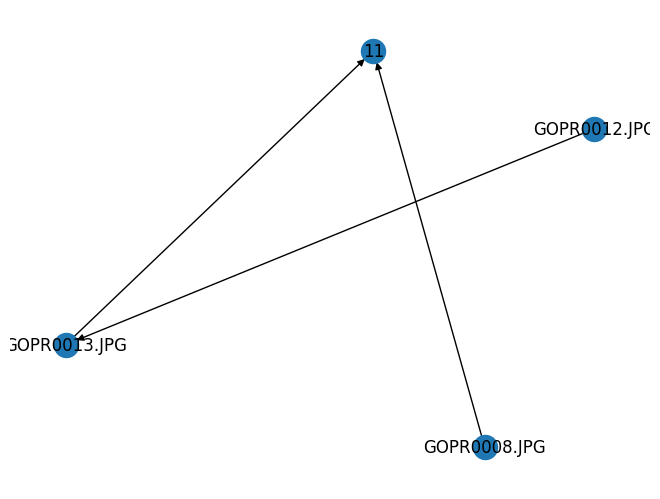

In [77]:
plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses)
plt.show(
)



In [78]:
pivot_node = "GOPR0012.JPG"
out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key]) for n in pose_graph.out_edges(pivot_node)] 
in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key]) for n in pose_graph.in_edges(pivot_node)] 
in_neighbors = [(n, inverse_transformation(t)) for (n,t) in in_neighbors] # this lets us handle every edge if it was outgoing
neighbors = out_neighbors + in_neighbors # every transformation now is a pose matrix (as opposed to extrinsic)
for neighbor, pose in neighbors:
    print(pose_graph.nodes[pivot_node][model_key])
    print(f"pose {pose}")
    print(pose_graph.nodes[neighbor][model_key])

    # add to pivot model applying pose
    new_pose = pose @ pose_graph.nodes[neighbor][model_key][neighbor]
    update_data(pose_graph, pivot_node, neighbor, new_pose)

    # get neighbors neighbors
    out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key],n) for n in pose_graph.out_edges(neighbor)] 
    in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key],n) for n in pose_graph.in_edges(neighbor)]
    in_neighbors = [(n, inverse_transformation(t),e) for (n,t,e) in in_neighbors]
    neighbors_neighbors = out_neighbors + in_neighbors
    # reconnect to pivot node applying pose to edge
    for nn, npose, edge in neighbors_neighbors:
        if nn == pivot_node:
            continue
        pose_graph.remove_edge(*edge)
        new_pose = pose @ npose
        pose_graph.add_edge(pivot_node, nn, **{trans_key: new_pose})
    pose_graph.remove_node(neighbor)


{'GOPR0012.JPG': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), 15: array([[ 0.14444374, -0.97338876, -0.17790538, -0.9081883 ],
       [-0.84022675, -0.02569094, -0.54162623, -0.26148593],
       [ 0.52264233,  0.22771537, -0.82157818,  1.38576549],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])}
pose [[ 0.16097715  0.98511074 -0.06035889 -0.73953705]
 [-0.96872423  0.16940863  0.18131213  0.28464947]
 [ 0.18883784  0.02928401  0.98157155 -0.02683687]
 [ 0.          0.          0.          1.        ]]
{'GOPR0013.JPG': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


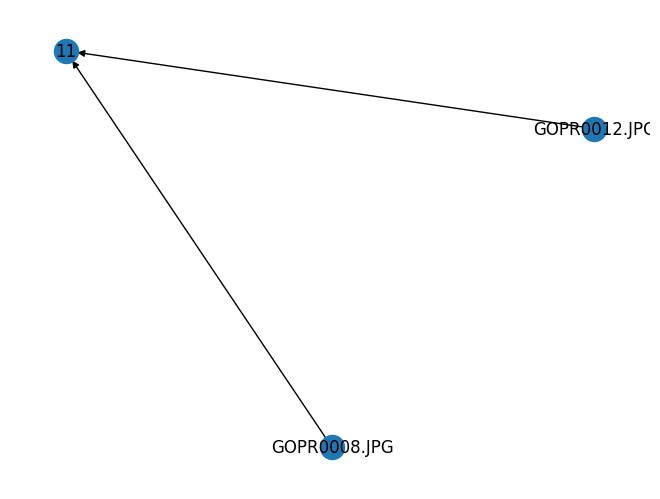

In [79]:
extrinsic_matrices = []
for node, trans in pose_graph.nodes[pivot_node][model_key].items():
    extrinsic_matrices.append((str(node),inverse_transformation(trans)))

# Define a list of extrinsic matrices (4x4)

wpts = np.zeros((0,3))

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses)
plt.show(
)


In [80]:
pivot_node = "GOPR0012.JPG"
out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key]) for n in pose_graph.out_edges(pivot_node)] 
in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key]) for n in pose_graph.in_edges(pivot_node)] 
in_neighbors = [(n, inverse_transformation(t)) for (n,t) in in_neighbors] # this lets us handle every edge if it was outgoing
neighbors = out_neighbors + in_neighbors # every transformation now is a pose matrix (as opposed to extrinsic)
for neighbor, pose in neighbors:
    print(pose_graph.nodes[pivot_node][model_key])
    print(f"pose {pose}")
    print(pose_graph.nodes[neighbor][model_key])

    # add to pivot model applying pose
    new_pose = pose @ pose_graph.nodes[neighbor][model_key][neighbor]
    update_data(pose_graph, pivot_node, neighbor, new_pose)

    # get neighbors neighbors
    out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key],n) for n in pose_graph.out_edges(neighbor)] 
    in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key],n) for n in pose_graph.in_edges(neighbor)]
    in_neighbors = [(n, inverse_transformation(t),e) for (n,t,e) in in_neighbors]
    neighbors_neighbors = out_neighbors + in_neighbors
    # reconnect to pivot node applying pose to edge
    for nn, npose, edge in neighbors_neighbors:
        if nn == pivot_node:
            continue
        pose_graph.remove_edge(*edge)
        new_pose = pose @ npose
        pose_graph.add_edge(pivot_node, nn, **{trans_key: new_pose})
    pose_graph.remove_node(neighbor)

{'GOPR0012.JPG': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), 15: array([[ 0.14444374, -0.97338876, -0.17790538, -0.9081883 ],
       [-0.84022675, -0.02569094, -0.54162623, -0.26148593],
       [ 0.52264233,  0.22771537, -0.82157818,  1.38576549],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'GOPR0013.JPG': array([[ 0.16097715,  0.98511074, -0.06035889, -0.73953705],
       [-0.96872423,  0.16940863,  0.18131213,  0.28464947],
       [ 0.18883784,  0.02928401,  0.98157155, -0.02683687],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])}
pose [[-0.76339957 -0.63137629  0.1363271  -0.54283737]
 [-0.6441403   0.7284543  -0.23331867  1.79165745]
 [ 0.04800382 -0.26592915 -0.96279661  2.96715808]
 [ 0.          0.          0.          1.        ]]
{11: array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


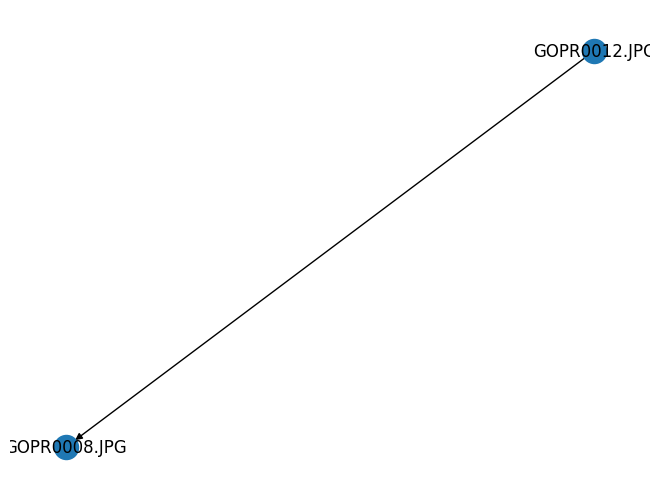

In [81]:
extrinsic_matrices = []
for node, trans in pose_graph.nodes[pivot_node][model_key].items():
    extrinsic_matrices.append((str(node),inverse_transformation(trans)))

# Define a list of extrinsic matrices (4x4)

wpts = np.zeros((0,3))

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses)
plt.show(
)

In [82]:
pivot_node = "GOPR0012.JPG"
out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key]) for n in pose_graph.out_edges(pivot_node)] 
in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key]) for n in pose_graph.in_edges(pivot_node)] 
in_neighbors = [(n, inverse_transformation(t)) for (n,t) in in_neighbors] # this lets us handle every edge if it was outgoing
neighbors = out_neighbors + in_neighbors # every transformation now is a pose matrix (as opposed to extrinsic)
for neighbor, pose in neighbors:
    print(pose_graph.nodes[pivot_node][model_key])
    print(f"pose {pose}")
    print(pose_graph.nodes[neighbor][model_key])

    # add to pivot model applying pose
    new_pose = pose @ pose_graph.nodes[neighbor][model_key][neighbor]
    update_data(pose_graph, pivot_node, neighbor, new_pose)

    # get neighbors neighbors
    out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key],n) for n in pose_graph.out_edges(neighbor)] 
    in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key],n) for n in pose_graph.in_edges(neighbor)]
    in_neighbors = [(n, inverse_transformation(t),e) for (n,t,e) in in_neighbors]
    neighbors_neighbors = out_neighbors + in_neighbors
    # reconnect to pivot node applying pose to edge
    for nn, npose, edge in neighbors_neighbors:
        if nn == pivot_node:
            continue
        pose_graph.remove_edge(*edge)
        new_pose = pose @ npose
        pose_graph.add_edge(pivot_node, nn, **{trans_key: new_pose})
    pose_graph.remove_node(neighbor)

{'GOPR0012.JPG': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), 15: array([[ 0.14444374, -0.97338876, -0.17790538, -0.9081883 ],
       [-0.84022675, -0.02569094, -0.54162623, -0.26148593],
       [ 0.52264233,  0.22771537, -0.82157818,  1.38576549],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 'GOPR0013.JPG': array([[ 0.16097715,  0.98511074, -0.06035889, -0.73953705],
       [-0.96872423,  0.16940863,  0.18131213,  0.28464947],
       [ 0.18883784,  0.02928401,  0.98157155, -0.02683687],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), 11: array([[-0.76339957, -0.63137629,  0.1363271 , -0.54283737],
       [-0.6441403 ,  0.7284543 , -0.23331867,  1.79165745],
       [ 0.04800382, -0.26592915, -0.96279661,  2.96715808],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])}
pose [[ 0.92753716 -0.36690193  0.07111811 -0.96000247]
 [ 0.21221822  0.36042849 -0.90832523  3.46380699]
 [ 0.3076332

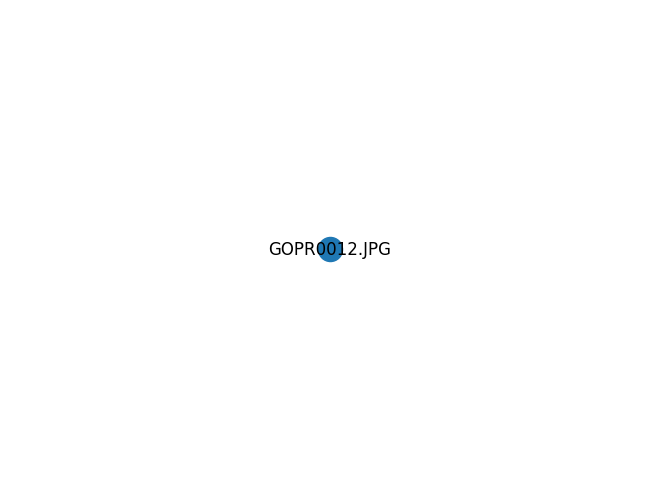

In [83]:
extrinsic_matrices = []
for node, trans in pose_graph.nodes[pivot_node][model_key].items():
    if str(node).endswith("JPG"):
        color = "blue"
    else:
        color = "orange"
    extrinsic_matrices.append((str(node),color, inverse_transformation(trans)))

# Define a list of extrinsic matrices (4x4)

wpts = np.zeros((0,3))

# Call the function to plot the points and camera representations
plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses)
plt.show(
)

## actually implement recursive graph resolution as formula

In [84]:
seed = 42
random.seed(seed)
np.random.seed(seed)
trans_key="trans"
model_key = "model"
def inverse_transformation(T):
    return np.linalg.inv(T)

def update_data(pose_graph, pivot_node, neighbor, new_trans):
    node_data = pose_graph.nodes[pivot_node]
    new_data = {pivot_node: {**node_data}}
    new_data[pivot_node][model_key][neighbor] = new_trans
    nx.set_node_attributes(pose_graph, new_data)

def preprocess(pose_graph, model_key=model_key):
    nodes = list(pose_graph.nodes)
    for n in nodes:
        n_data = pose_graph[n]
        nx.set_node_attributes(pose_graph, {n:{model_key: {n: np.eye(4)},**n_data}})

In [89]:
def recursive_pose_graph_collapse(pose_graph, pivot_node, model_key, trans_key):
    out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key]) for n in pose_graph.out_edges(pivot_node)] 
    in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key]) for n in pose_graph.in_edges(pivot_node)] 
    in_neighbors = [(n, inverse_transformation(t)) for (n,t) in in_neighbors] # this lets us handle every edge if it was outgoing
    neighbors = out_neighbors + in_neighbors # every transformation now is a pose matrix (as opposed to extrinsic)
    
    if len(neighbors) == 0:
        return pose_graph
    
    next_graph = pose_graph.copy()
    for neighbor, pose in neighbors:
        print(neighbor)
        # print(pose_graph.nodes[pivot_node][model_key])
        # print(f"pose {pose}")
        # print(pose_graph.nodes[neighbor][model_key])

        # add to pivot model applying pose
        new_pose = pose @ pose_graph.nodes[neighbor][model_key][neighbor]
        update_data(next_graph, pivot_node, neighbor, new_pose)

        # get neighbors neighbors
        out_neighbors = [ (n[1], pose_graph.edges[*n][trans_key],n) for n in pose_graph.out_edges(neighbor)] 
        in_neighbors = [ (n[0], pose_graph.edges[*n][trans_key],n) for n in pose_graph.in_edges(neighbor)]
        in_neighbors = [(n, inverse_transformation(t),e) for (n,t,e) in in_neighbors]
        neighbors_neighbors = out_neighbors + in_neighbors
        
        # reconnect to pivot node applying pose to edge
        for nn, npose, edge in neighbors_neighbors:
            if nn == pivot_node:
                continue
            next_graph.remove_edge(*edge)
            new_pose = pose @ npose
            next_graph.add_edge(pivot_node, nn, **{trans_key: new_pose})
        next_graph.remove_node(neighbor)
    
    return recursive_pose_graph_collapse(next_graph, pivot_node,model_key,trans_key)

graph consists of 1 connected component(s), choosing largest
15
12
14
GOPR0009.JPG
GOPR0010.JPG
GOPR0013.JPG
GOPR0011.JPG
10
13
11
GOPR0008.JPG
GOPR0014.JPG
GOPR0007.JPG


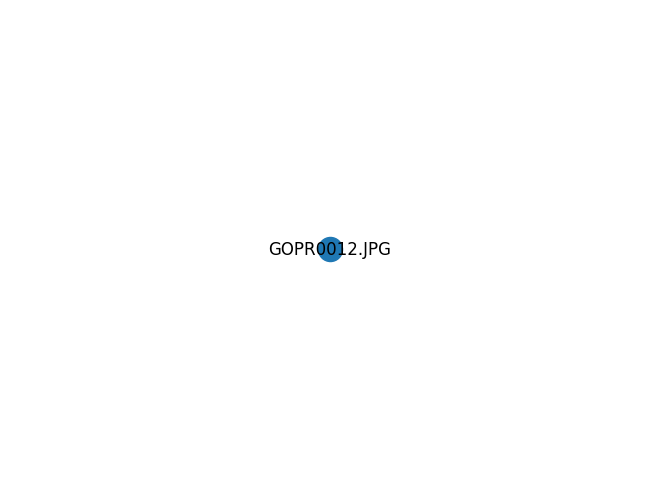

In [90]:
import networkx as nx
import random
import numpy as np
import pathlib
seed = 42
random.seed(seed)
np.random.seed(seed)

# build graph
pose_graph = nx.DiGraph()
for img_path in image_paths:
    rvecs, tvecs, marker_ids, objpts = estimate_april_pose(img_path)
    img_markers = dict()
    node_name = pathlib.Path(img_path).name
    pose_graph.add_node(node_name)
    for rvec, tvec, mid in zip(rvecs, tvecs, marker_ids):
        wpts, trans = convert_to_cam_system(rvec, tvec, marker_world_corners=objpts.reshape((-1,3)))
        # note that these trans tranforms are pose matrices
        img_markers[mid] = (wpts, trans)
        if not pose_graph.has_node(mid):
            pose_graph.add_node(mid)
        
        pose_graph.add_edge(node_name, mid, trans=trans, points3d=wpts.T)

# select largest connected component
components = sorted(nx.connected_components(nx.Graph(pose_graph)), key=len, reverse=True)
pose_graph = pose_graph.subgraph(components[0])
print(f"graph consists of {len(components)} connected component(s), choosing largest")

# execute graph collapse

# (uses side effect)
preprocess(pose_graph, model_key=model_key)
pose_graph = recursive_pose_graph_collapse(pose_graph, pivot_node, model_key, trans_key)

# visualize
extrinsic_matrices = []
for node, trans in pose_graph.nodes[pivot_node][model_key].items():
    if str(node).endswith("JPG"):
        color = "blue"
    else:
        color = "orange"
    extrinsic_matrices.append((str(node),color, inverse_transformation(trans)))

wpts = np.zeros((0,3))

plot_3d_points_and_camera_centers(wpts.T, extrinsic_matrices)

plt.figure()
nx.draw(pose_graph, with_labels=True, pos=graph_poses)
plt.show(
)